ref_dirs.shape: (1771, 4)


<IPython.core.display.Javascript object>


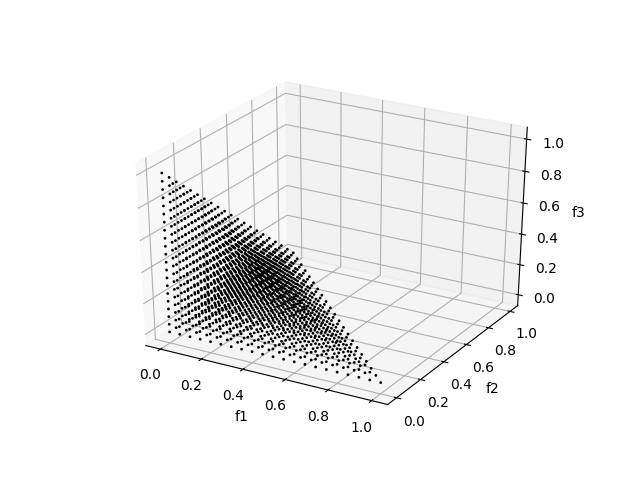

In [13]:
%matplotlib notebook
%reload_ext autoreload
%autoreload 2

import sys

sys.path.append('../')
sys.path.append('../paretoviz')

import matplotlib.pyplot as plt
import autograd.numpy as anp

from pymoo.optimize import minimize
from pymoo.algorithms.nsga2 import nsga2
from pymoo.algorithms.nsga3 import nsga3
from pymoo.util import plotting
from pymop.factory import get_problem
from pymop.problem import Problem
from pymoo.util.reference_direction import MultiLayerReferenceDirectionFactory
from pymoo.util.reference_direction import UniformReferenceDirectionFactory
from pymoo.util import plotting

from paretoviz import plotting as pplt

class osy_nd(Problem):
    def __init__(self, n_obj = 2, n_constr = 6):
        self.n_obj = n_obj
        self.n_constr = n_constr
        super().__init__(n_var = 6, n_obj = self.n_obj, n_constr = self.n_constr, \
                         type_var = anp.double)
        self.xl = anp.array([0.0, 0.0, 1.0, 0.0, 1.0, 0.0])
        self.xu = anp.array([10.0, 10.0, 5.0, 6.0, 5.0, 10.0])

    def _evaluate(self, x, out, *args, **kwargs):
        f = [0] * 8
        g = [0] * 6
        f[0] = - (25 * anp.square(x[:, 0] - 2) + anp.square(x[:, 1] - 2) \
                + anp.square(x[:, 2] - 1) + anp.square(x[:, 3] - 4) \
                + anp.square(x[:, 4] - 1))
        f[1] = anp.sum(anp.square(x), axis = 1)
        f[2] = (x[:, 0] + x[:, 1] - 2.0) / 2.0
        f[3] = (6.0 - x[:, 0] - x[:, 1]) / 6.0
        f[4] = (2.0 - x[:, 1] + x[:, 0]) / 2.0
        f[5] = (2.0 - x[:, 0] + 3.0 * x[:, 1]) / 2.0
        f[6] = (4.0 - anp.square(x[:, 2] - 3.0) - x[:, 3]) / 4.0
        f[7] = (anp.square(x[:, 4] - 3.0) + x[:, 5] - 4.0) / 4.0
        
        g[0] = f[2]
        g[1] = f[3]
        g[2] = f[4]
        g[3] = f[5]
        g[4] = f[6]
        g[5] = f[7]

        out["F"] = anp.column_stack(f[0:self.n_obj])
        out["G"] = - anp.column_stack(g[0:self.n_constr])

# algo parameters
n_dim = 4
npop = 2000 #if n_dim <= 3 else 2000
ref_dirs = UniformReferenceDirectionFactory(n_dim, n_points = npop).do()
# ref_dirs = MultiLayerReferenceDirectionFactory([\
#     UniformReferenceDirectionFactory(n_dim, n_partitions = 10, scaling = 1.0),\
#     UniformReferenceDirectionFactory(n_dim, n_partitions = 10, scaling = 0.9),\
#     UniformReferenceDirectionFactory(n_dim, n_partitions = 9, scaling = 0.8),\
#     UniformReferenceDirectionFactory(n_dim, n_partitions = 7, scaling = 0.7),\
#     UniformReferenceDirectionFactory(n_dim, n_partitions = 6, scaling = 0.6),\
#     UniformReferenceDirectionFactory(n_dim, n_partitions = 5, scaling = 0.5),\
#     UniformReferenceDirectionFactory(n_dim, n_partitions = 4, scaling = 0.4),\
#     UniformReferenceDirectionFactory(n_dim, n_partitions = 3, scaling = 0.3),\
#     UniformReferenceDirectionFactory(n_dim, n_partitions = 2, scaling = 0.2),\
#     UniformReferenceDirectionFactory(n_dim, n_partitions = 1, scaling = 0.1),\
# ]).do()

print("ref_dirs.shape:", ref_dirs.shape)

# Just plot the ref_dirs to see how do they look like.

# rd = ref_dirs.tolist()
# print(rd[0:10])

# do the scatter plot
(fig, ax) = pplt.scatter(ref_dirs.tolist())
# save the scatter plot
# scatterfpath = os.path.join(".", prefix + "-scatter.pdf")
# plt.savefig(scatterfpath, transparent = False)

plt.show()

Running nsga3
n_gen | n_eval  | cv (min/avg) 
1     | 2000    | 0.00000 / 1.66878
2     | 4000    | 0.00000 / 0.57042
3     | 6000    | 0.00000 / 0.15989
4     | 8000    | 0.00000 / 0.00797
5     | 10000   | 0.00000 / 0.00000
6     | 12000   | 0.00000 / 0.00000
7     | 14000   | 0.00000 / 0.00000
8     | 16000   | 0.00000 / 0.00000
9     | 18000   | 0.00000 / 0.00000
10    | 20000   | 0.00000 / 0.00000
11    | 22000   | 0.00000 / 0.00000
12    | 24000   | 0.00000 / 0.00000
13    | 26000   | 0.00000 / 0.00000
14    | 28000   | 0.00000 / 0.00000
15    | 30000   | 0.00000 / 0.00000
16    | 32000   | 0.00000 / 0.00000
17    | 34000   | 0.00000 / 0.00000
18    | 36000   | 0.00000 / 0.00000
19    | 38000   | 0.00000 / 0.00000
20    | 40000   | 0.00000 / 0.00000
21    | 42000   | 0.00000 / 0.00000
22    | 44000   | 0.00000 / 0.00000
23    | 46000   | 0.00000 / 0.00000
24    | 48000   | 0.00000 / 0.00000
25    | 50000   | 0.00000 / 0.00000
26    | 52000   | 0.00000 / 0.00000
27    | 54000   | 

225   | 450000  | 0.00000 / 0.00000
226   | 452000  | 0.00000 / 0.00000
227   | 454000  | 0.00000 / 0.00000
228   | 456000  | 0.00000 / 0.00000
229   | 458000  | 0.00000 / 0.00000
230   | 460000  | 0.00000 / 0.00000
231   | 462000  | 0.00000 / 0.00000
232   | 464000  | 0.00000 / 0.00000
233   | 466000  | 0.00000 / 0.00000
234   | 468000  | 0.00000 / 0.00000
235   | 470000  | 0.00000 / 0.00000
236   | 472000  | 0.00000 / 0.00000
237   | 474000  | 0.00000 / 0.00000
238   | 476000  | 0.00000 / 0.00000
239   | 478000  | 0.00000 / 0.00000
240   | 480000  | 0.00000 / 0.00000
241   | 482000  | 0.00000 / 0.00000
242   | 484000  | 0.00000 / 0.00000
243   | 486000  | 0.00000 / 0.00000
244   | 488000  | 0.00000 / 0.00000
245   | 490000  | 0.00000 / 0.00000
246   | 492000  | 0.00000 / 0.00000
247   | 494000  | 0.00000 / 0.00000
248   | 496000  | 0.00000 / 0.00000
249   | 498000  | 0.00000 / 0.00000
250   | 500000  | 0.00000 / 0.00000
251   | 502000  | 0.00000 / 0.00000
252   | 504000  | 0.00000 / 

453   | 906000  | 0.00000 / 0.00000
454   | 908000  | 0.00000 / 0.00000
455   | 910000  | 0.00000 / 0.00000
456   | 912000  | 0.00000 / 0.00000
457   | 914000  | 0.00000 / 0.00000
458   | 916000  | 0.00000 / 0.00000
459   | 918000  | 0.00000 / 0.00000
460   | 920000  | 0.00000 / 0.00000
461   | 922000  | 0.00000 / 0.00000
462   | 924000  | 0.00000 / 0.00000
463   | 926000  | 0.00000 / 0.00000
464   | 928000  | 0.00000 / 0.00000
465   | 930000  | 0.00000 / 0.00000
466   | 932000  | 0.00000 / 0.00000
467   | 934000  | 0.00000 / 0.00000
468   | 936000  | 0.00000 / 0.00000
469   | 938000  | 0.00000 / 0.00000
470   | 940000  | 0.00000 / 0.00000
471   | 942000  | 0.00000 / 0.00000
472   | 944000  | 0.00000 / 0.00000
473   | 946000  | 0.00000 / 0.00000
474   | 948000  | 0.00000 / 0.00000
475   | 950000  | 0.00000 / 0.00000
476   | 952000  | 0.00000 / 0.00000
477   | 954000  | 0.00000 / 0.00000
478   | 956000  | 0.00000 / 0.00000
479   | 958000  | 0.00000 / 0.00000
480   | 960000  | 0.00000 / 

<IPython.core.display.Javascript object>


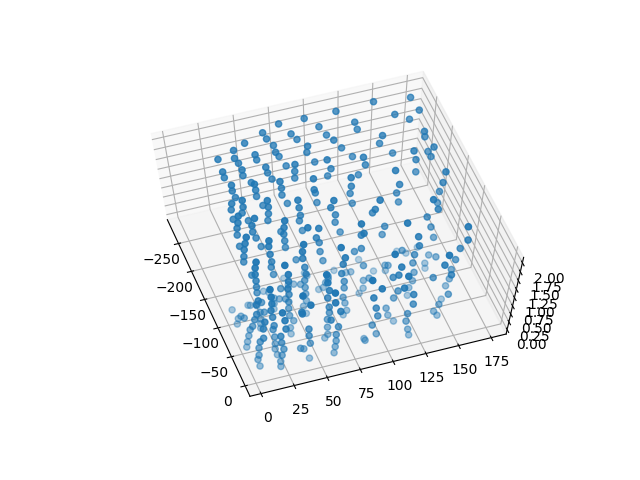

In [14]:
# # load a test or define your own problem
problem = osy_nd(n_obj = n_dim)

# get the optimal solution of the problem for the purpose of comparison
pf = problem.pareto_front()

# create the algorithm object
if n_dim <= 3:
    print("Running nsga2")
    method = nsga2(pop_size = npop, elimate_duplicates = True)
else:
    print("Running nsga3")
    method = nsga3(ref_dirs, pop_size = npop, elimate_duplicates = True)

# execute the optimization
res = minimize(problem,
               method,
               termination = ('n_gen', 500),
               pf = pf,
               disp = True)

fp = open("osy-{0:d}d.out".format(n_dim), "w")
F = res.F.tolist()
for f in F:
    fp.write("\t".join(["{0:.4f}".format(v) for v in f]) + "\n")
fp.close()

fp = open("osy-{0:d}d-x.out".format(n_dim), "w")
F = res.X.tolist()
for f in F:
    fp.write("\t".join(["{0:.4f}".format(v) for v in f]) + "\n")
fp.close()

fp = open("osy-{0:d}d-cv.out".format(n_dim), "w")
F = res.G.tolist()
for f in F:
    fp.write("\t".join(["{0:.4f}".format(v) for v in f]) + "\n")
fp.close()

print("\nObjective Space")
plotting.plot(res.F[:,0:3], no_fill = True)